In [9]:
# Importações

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, year, dayofmonth, dayofweek, lag, avg
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import random
from pprint import pprint

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [10]:
# Inicializar Spark

spark = SparkSession.builder \
    .appName("Previsao_Vendas") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

print("Spark Session iniciada com sucesso!")

Spark Session iniciada com sucesso!


In [11]:
# Criar dados de venda fictício

data_inicio = datetime(2022, 1, 1)
dados = []

for i in range(730):  # 2 anos de dados
    data = data_inicio + timedelta(days=i)
    
    # Padrão semanal (mais vendas no fim de semana)
    dia_semana = data.weekday()
    mult_semana = 1.3 if dia_semana >= 5 else 1.0
    
    # Sazonalidade mensal (mais vendas no final do ano)
    mes = data.month
    mult_mes = 1.5 if mes in [11, 12] else (0.8 if mes in [1, 2] else 1.0)
    
    # Tendência de crescimento
    tendencia = 1 + (i / 730) * 0.5
    
    # Base + padrões + ruído
    vendas = int(1000 * tendencia * mult_semana * mult_mes * random.uniform(0.8, 1.2))
    
    dados.append({
        'data': data.strftime('%Y-%m-%d'),
        'vendas': vendas,
        'promocao': 1 if random.random() > 0.8 else 0,
        'temperatura': random.randint(15, 35)
    })


pprint(dados[:5])

[{'data': '2022-01-01', 'promocao': 0, 'temperatura': 15, 'vendas': 1196},
 {'data': '2022-01-02', 'promocao': 0, 'temperatura': 24, 'vendas': 959},
 {'data': '2022-01-03', 'promocao': 0, 'temperatura': 18, 'vendas': 885},
 {'data': '2022-01-04', 'promocao': 0, 'temperatura': 21, 'vendas': 763},
 {'data': '2022-01-05', 'promocao': 0, 'temperatura': 34, 'vendas': 723}]


In [4]:
# Criar DataFrame

df = spark.createDataFrame(dados)

print(f"\nDataset criado: {df.count()} registros")
print("\nPrimeiras linhas:")
df.show(10)

# Salvar CSV
df.coalesce(1).write.mode('overwrite').option('header', 'true').csv('vendas_ficticias.csv')
print("CSV salvo em 'vendas_ficticias.csv'")


Dataset criado: 730 registros

Primeiras linhas:
+----------+--------+-----------+------+
|      data|promocao|temperatura|vendas|
+----------+--------+-----------+------+
|2022-01-01|       0|         17|  1136|
|2022-01-02|       0|         22|  1204|
|2022-01-03|       1|         25|   844|
|2022-01-04|       0|         24|   888|
|2022-01-05|       0|         35|   912|
|2022-01-06|       0|         31|   952|
|2022-01-07|       0|         30|   666|
|2022-01-08|       0|         17|  1227|
|2022-01-09|       0|         25|   876|
|2022-01-10|       0|         20|   842|
+----------+--------+-----------+------+
only showing top 10 rows
CSV salvo em 'vendas_ficticias.csv'


In [5]:
# Engenharia de Features

# Converter data para timestamp
df = df.withColumn('data', col('data').cast('date'))

# Extrair features temporais
df = df.withColumn('ano', year('data'))
df = df.withColumn('mes', month('data'))
df = df.withColumn('dia', dayofmonth('data'))
df = df.withColumn('dia_semana', dayofweek('data'))

# Criar features de lag (vendas dos últimos 7 dias)
window_spec = Window.orderBy('data')
for i in range(1, 8):
    df = df.withColumn(f'vendas_lag_{i}', lag('vendas', i).over(window_spec))

# Média móvel de 7 dias
window_7d = Window.orderBy('data').rowsBetween(-7, -1)
df = df.withColumn('media_movel_7d', avg('vendas').over(window_7d))

# Remover linhas com valores nulos (primeiros 7 dias sem lag)
df = df.na.drop()

print(f"\nFeatures criadas! Total de registros após limpeza: {df.count()}")
print("\nSchema do dataset:")
df.printSchema()


Features criadas! Total de registros após limpeza: 723

Schema do dataset:
root
 |-- data: date (nullable = true)
 |-- promocao: long (nullable = true)
 |-- temperatura: long (nullable = true)
 |-- vendas: long (nullable = true)
 |-- ano: integer (nullable = true)
 |-- mes: integer (nullable = true)
 |-- dia: integer (nullable = true)
 |-- dia_semana: integer (nullable = true)
 |-- vendas_lag_1: long (nullable = true)
 |-- vendas_lag_2: long (nullable = true)
 |-- vendas_lag_3: long (nullable = true)
 |-- vendas_lag_4: long (nullable = true)
 |-- vendas_lag_5: long (nullable = true)
 |-- vendas_lag_6: long (nullable = true)
 |-- vendas_lag_7: long (nullable = true)
 |-- media_movel_7d: double (nullable = true)



In [6]:
# Preparar dados para o ML

feature_cols = [
    'mes', 'dia', 'dia_semana', 'promocao', 'temperatura',
    'vendas_lag_1', 'vendas_lag_2', 'vendas_lag_3', 'vendas_lag_7',
    'media_movel_7d'
]

# Assembler para criar vetor de features
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features_raw'
)

# Scaler para normalizar features
scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withStd=True,
    withMean=True
)

# Split treino/teste (80/20)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print(f"\n✓ Dados divididos:")
print(f"   Treino: {train_df.count()} registros")
print(f"   Teste: {test_df.count()} registros")


✓ Dados divididos:
   Treino: 606 registros
   Teste: 117 registros


In [7]:
# Treinar modelos

print("\n" + "="*50)
print("TREINANDO MODELOS")
print("="*50)

# Modelo 1: Regressão Linear
lr = LinearRegression(
    featuresCol='features',
    labelCol='vendas',
    maxIter=100
)

pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
modelo_lr = pipeline_lr.fit(train_df)

print("Modelo de Regressão Linear treinado")

# Modelo 2: Random Forest
rf = RandomForestRegressor(
    featuresCol='features',
    labelCol='vendas',
    numTrees=50,
    maxDepth=10,
    seed=42
)

pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
modelo_rf = pipeline_rf.fit(train_df)

print("Modelo Random Forest treinado")


TREINANDO MODELOS
Modelo de Regressão Linear treinado
Modelo Random Forest treinado


In [8]:
# Avaliar modelos

print("\n" + "="*50)
print("AVALIAÇÃO DOS MODELOS")
print("="*50)

# Fazer previsões
pred_lr = modelo_lr.transform(test_df)
pred_rf = modelo_rf.transform(test_df)

# Avaliadores
evaluator_rmse = RegressionEvaluator(
    labelCol='vendas',
    predictionCol='prediction',
    metricName='rmse'
)

evaluator_r2 = RegressionEvaluator(
    labelCol='vendas',
    predictionCol='prediction',
    metricName='r2'
)

evaluator_mae = RegressionEvaluator(
    labelCol='vendas',
    predictionCol='prediction',
    metricName='mae'
)

# Métricas Regressão Linear
rmse_lr = evaluator_rmse.evaluate(pred_lr)
r2_lr = evaluator_r2.evaluate(pred_lr)
mae_lr = evaluator_mae.evaluate(pred_lr)

print(f"\n📊 Regressão Linear:")
print(f"   RMSE: {rmse_lr:.2f}")
print(f"   R²: {r2_lr:.4f}")
print(f"   MAE: {mae_lr:.2f}")

# Métricas Random Forest
rmse_rf = evaluator_rmse.evaluate(pred_rf)
r2_rf = evaluator_r2.evaluate(pred_rf)
mae_rf = evaluator_mae.evaluate(pred_rf)

print(f"\n📊 Random Forest:")
print(f"   RMSE: {rmse_rf:.2f}")
print(f"   R²: {r2_rf:.4f}")
print(f"   MAE: {mae_rf:.2f}")


AVALIAÇÃO DOS MODELOS

📊 Regressão Linear:
   RMSE: 225.38
   R²: 0.7747
   MAE: 188.69

📊 Random Forest:
   RMSE: 213.60
   R²: 0.7976
   MAE: 175.71


In [9]:
# Previsões futuras

print("\n" + "="*50)
print("PREVISÕES PARA OS PRÓXIMOS 30 DIAS")
print("="*50)

# Escolher melhor modelo
melhor_modelo = modelo_rf if rmse_rf < rmse_lr else modelo_lr
nome_modelo = "Random Forest" if rmse_rf < rmse_lr else "Regressão Linear"

print(f"\n✓ Usando modelo: {nome_modelo}")

# Pegar últimos dados para fazer previsões
ultimos_dados = df.orderBy(col('data').desc()).limit(1).collect()[0]
ultima_data = ultimos_dados['data']

# Simular previsões futuras (próximos 30 dias)
previsoes_futuras = []

for i in range(1, 31):
    data_futura = ultima_data + timedelta(days=i)
    
    dados_futuros = [{
        'data': data_futura,
        'mes': data_futura.month,
        'dia': data_futura.day,
        'dia_semana': data_futura.isoweekday(),
        'promocao': 1 if i % 7 == 0 else 0,  # Promoção semanal
        'temperatura': random.randint(20, 30),
        'vendas_lag_1': ultimos_dados['vendas'],
        'vendas_lag_2': ultimos_dados['vendas_lag_1'],
        'vendas_lag_3': ultimos_dados['vendas_lag_2'],
        'vendas_lag_7': ultimos_dados['vendas_lag_7'],
        'media_movel_7d': ultimos_dados['media_movel_7d']
    }]
    
    df_futuro = spark.createDataFrame(dados_futuros)
    previsao = melhor_modelo.transform(df_futuro)
    valor_previsto = previsao.select('prediction').collect()[0][0]
    
    previsoes_futuras.append({
        'data': data_futura.strftime('%Y-%m-%d'),
        'vendas_previstas': int(valor_previsto)
    })

# Mostrar previsões
df_previsoes = spark.createDataFrame(previsoes_futuras)
print("\n📈 Previsões para os próximos 30 dias:")
df_previsoes.show(30)

# Calcular totais
total_previsto = sum([p['vendas_previstas'] for p in previsoes_futuras])
media_prevista = total_previsto / 30

print(f"\n💰 Resumo das Previsões:")
print(f"   Total previsto (30 dias): {total_previsto:,} unidades")
print(f"   Média diária prevista: {media_prevista:.0f} unidades")


PREVISÕES PARA OS PRÓXIMOS 30 DIAS

✓ Usando modelo: Random Forest

📈 Previsões para os próximos 30 dias:
+----------+----------------+
|      data|vendas_previstas|
+----------+----------------+
|2024-01-01|            2079|
|2024-01-02|            1957|
|2024-01-03|            1934|
|2024-01-04|            1960|
|2024-01-05|            1984|
|2024-01-06|            2010|
|2024-01-07|            2159|
|2024-01-08|            2085|
|2024-01-09|            1941|
|2024-01-10|            2020|
|2024-01-11|            2036|
|2024-01-12|            2018|
|2024-01-13|            2029|
|2024-01-14|            2237|
|2024-01-15|            2147|
|2024-01-16|            2044|
|2024-01-17|            2052|
|2024-01-18|            2034|
|2024-01-19|            2074|
|2024-01-20|            2080|
|2024-01-21|            2183|
|2024-01-22|            2219|
|2024-01-23|            1962|
|2024-01-24|            1932|
|2024-01-25|            2005|
|2024-01-26|            1953|
|2024-01-27|           


GERANDO VISUALIZAÇÕES
✓ Gráfico salvo como 'analise_vendas_pyspark.png'


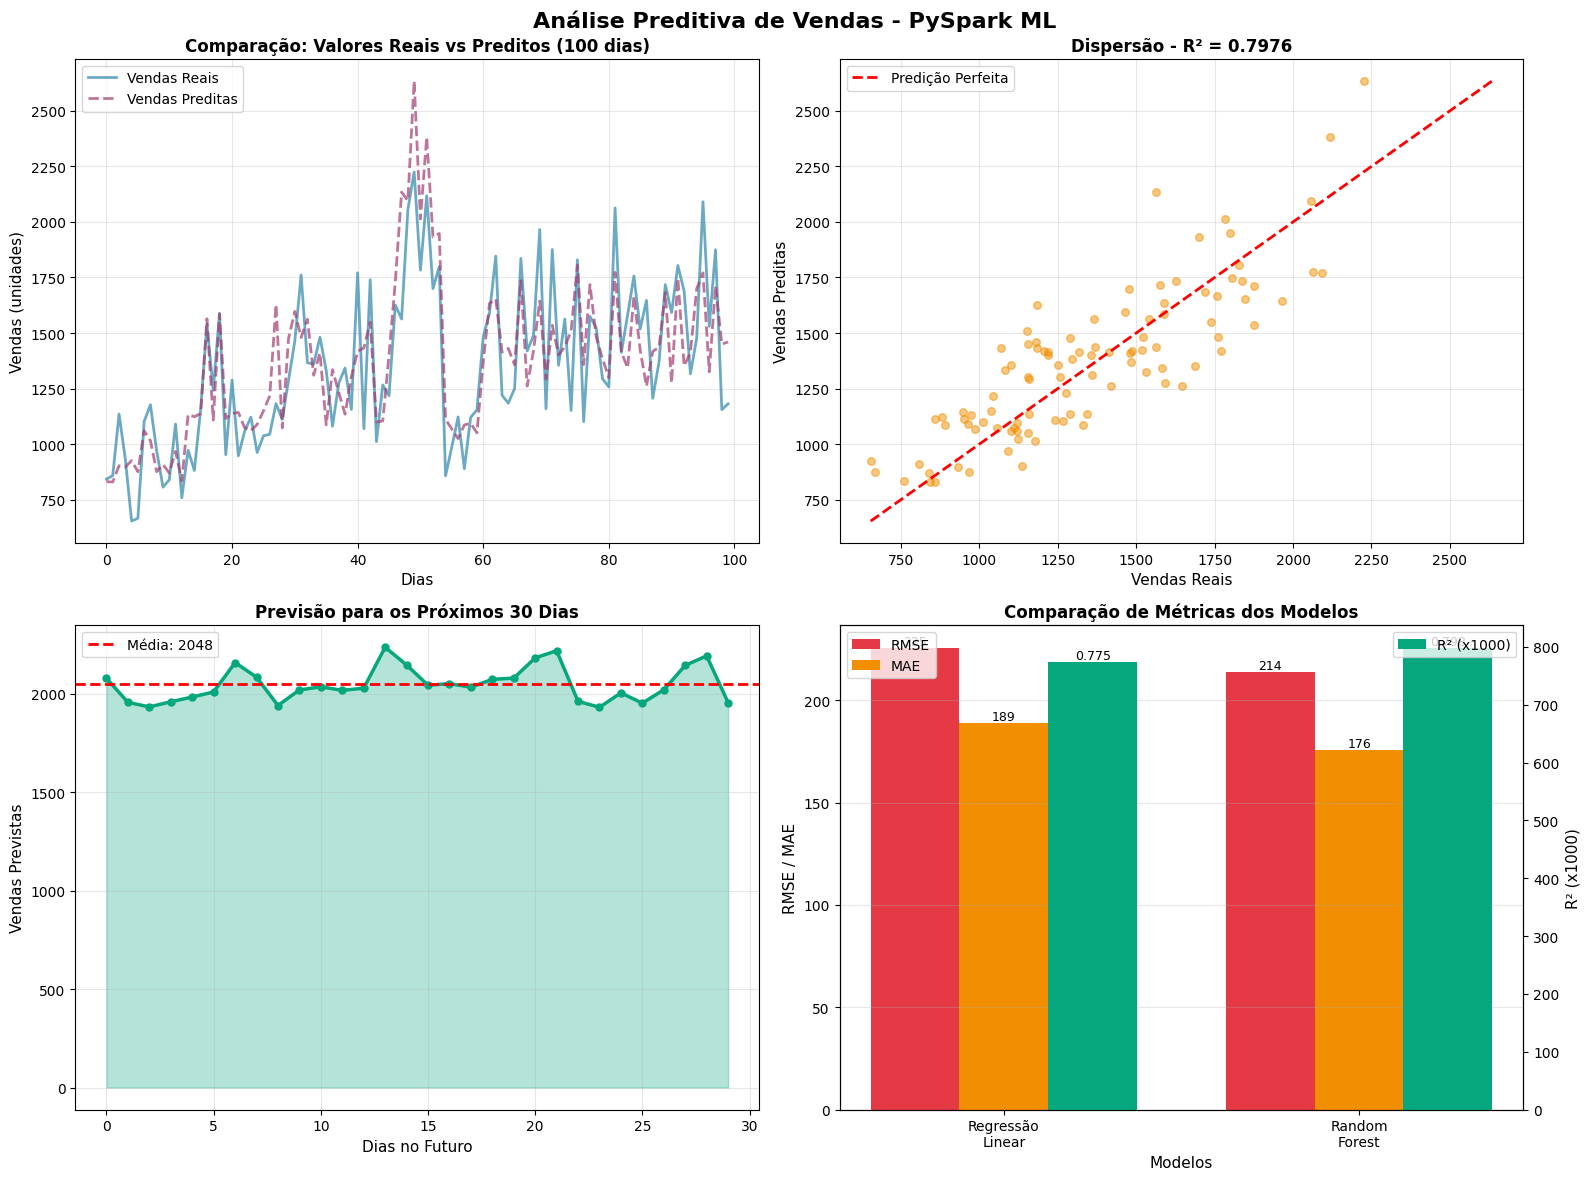

In [10]:
print("\n" + "="*50)
print("GERANDO VISUALIZAÇÕES")
print("="*50)

# Coletar dados para visualização (convertendo para listas Python)
# Pegamos 100 pontos do conjunto de teste para visualização

# Dados reais vs predições do melhor modelo
viz_data = pred_rf.select('data', 'vendas', 'prediction').orderBy('data').limit(100).collect()

datas = [row['data'] for row in viz_data]
vendas_reais = [row['vendas'] for row in viz_data]
vendas_pred = [row['prediction'] for row in viz_data]

# Previsões futuras
prev_futuras_data = [p['data'] for p in previsoes_futuras]
prev_futuras_valores = [p['vendas_previstas'] for p in previsoes_futuras]

# Criar figura com múltiplos gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Preditiva de Vendas - PySpark ML', fontsize=16, fontweight='bold')

# ---- GRÁFICO 1: Real vs Predito ----
axes[0, 0].plot(range(len(vendas_reais)), vendas_reais, 
                label='Vendas Reais', color='#2E86AB', linewidth=2, alpha=0.7)
axes[0, 0].plot(range(len(vendas_pred)), vendas_pred, 
                label='Vendas Preditas', color='#A23B72', linewidth=2, alpha=0.7, linestyle='--')
axes[0, 0].set_xlabel('Dias', fontsize=11)
axes[0, 0].set_ylabel('Vendas (unidades)', fontsize=11)
axes[0, 0].set_title('Comparação: Valores Reais vs Preditos (100 dias)', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# ---- GRÁFICO 2: Scatter Plot (Real vs Predito) ----
axes[0, 1].scatter(vendas_reais, vendas_pred, alpha=0.5, color='#F18F01', s=30)
# Linha diagonal perfeita
min_val = min(min(vendas_reais), min(vendas_pred))
max_val = max(max(vendas_reais), max(vendas_pred))
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 
                'r--', linewidth=2, label='Predição Perfeita')
axes[0, 1].set_xlabel('Vendas Reais', fontsize=11)
axes[0, 1].set_ylabel('Vendas Preditas', fontsize=11)
axes[0, 1].set_title(f'Dispersão - R² = {r2_rf:.4f}', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ---- GRÁFICO 3: Previsões Futuras ----
axes[1, 0].plot(range(len(prev_futuras_valores)), prev_futuras_valores, 
                marker='o', color='#06A77D', linewidth=2.5, markersize=5)
axes[1, 0].axhline(y=media_prevista, color='red', linestyle='--', 
                   linewidth=2, label=f'Média: {media_prevista:.0f}')
axes[1, 0].fill_between(range(len(prev_futuras_valores)), 
                        prev_futuras_valores, alpha=0.3, color='#06A77D')
axes[1, 0].set_xlabel('Dias no Futuro', fontsize=11)
axes[1, 0].set_ylabel('Vendas Previstas', fontsize=11)
axes[1, 0].set_title('Previsão para os Próximos 30 Dias', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ---- GRÁFICO 4: Comparação de Métricas dos Modelos ----
modelos = ['Regressão\nLinear', 'Random\nForest']
rmse_valores = [rmse_lr, rmse_rf]
r2_valores = [r2_lr * 1000, r2_rf * 1000]  # Multiplicar R² para mesma escala visual
mae_valores = [mae_lr, mae_rf]

x = np.arange(len(modelos))
width = 0.25

bars1 = axes[1, 1].bar(x - width, rmse_valores, width, label='RMSE', color='#E63946')
bars2 = axes[1, 1].bar(x, mae_valores, width, label='MAE', color='#F18F01')
# R² em escala separada (eixo Y direito)
ax2 = axes[1, 1].twinx()
bars3 = ax2.bar(x + width, r2_valores, width, label='R² (x1000)', color='#06A77D')

axes[1, 1].set_xlabel('Modelos', fontsize=11)
axes[1, 1].set_ylabel('RMSE / MAE', fontsize=11)
ax2.set_ylabel('R² (x1000)', fontsize=11)
axes[1, 1].set_title('Comparação de Métricas dos Modelos', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(modelos)
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.0f}', ha='center', va='bottom', fontsize=9)

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height/1000:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('analise_vendas_pyspark.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico salvo como 'analise_vendas_pyspark.png'")
plt.show()